# Context
To be completely sure that we are rid of any potential model-data discrapancies, Vivienne suggests to do the following test:
1. Take Yirui's true SFH, and fit an approximation with the psb_wild2020 functional form, to get best fit parameters on that fit
2. Use the best fit parameters to generate a spectrum with bagpipes, with sensible other galaxy parameters
3. Use bagpipes to fit for this spectrum (assume SNR = 15, no observational error purtubation), bin by 1, with R_spec = 1000, 1800, 3000,4340
4. Compare the posterior estimates' predicted spectrum with the spectrum from step 2
First, fit a psb_wild2020 to the true SFH

In [218]:
import bagpipes as pipes
# setting bagpipes R_spec to as high as possible for perfect generation of models
pipes.config.R_spec = 10000
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy
import pandas as pd
from PyAstronomy import pyasl
import seaborn as sns
import pandas as pd

## Step 1: use scipy.optimize.curve_fit to fit a psb2 function to the true SFH

In [168]:
age_at_z = pipes.utils.cosmo.age(0).value
sim_data = np.loadtxt('../Yirui_test_cube/snap119/2xSc_07_EC_BH_vw1e4_ReposNoRFBNoRP_snap119_SFH_at_diff_radius.txt')
model_sfh = sim_data[:,2]
model_ages = sim_data[:,0]
mask = model_ages > 0
model_ages = model_ages[mask].copy()
model_sfh = model_sfh[mask].copy()


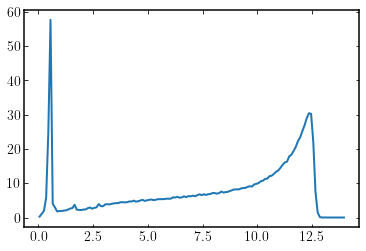

In [169]:
plt.plot(model_ages, model_sfh)

In [170]:
# extracted from bagpipes.models.star_formation_history.py, with a bit of tweaking
def psb_wild2020(age_list, age, tau, burstage, alpha, beta, fburst, Mstar):
    """
    A 2-component SFH for post-starburst galaxies. An exponential
    compoent represents the existing stellar population before the
    starburst, while a double power law makes up the burst.
    The weight of mass formed between the two is controlled by a
    fburst factor: thefraction of mass formed in the burst.
    For more detail, see Wild et al. 2020
    (https://ui.adsabs.harvard.edu/abs/2020MNRAS.494..529W/abstract)
    """
    age_lhs = pipes.utils.make_bins(np.log10(age_list)+9, make_rhs=True)[0]
    age_list = age_list*10**9
    age_lhs = 10**age_lhs
    age_lhs[0] = 0.
    age_lhs[-1] = 10**9*pipes.utils.age_at_z[pipes.utils.z_array == 0.]
    age_widths = age_lhs[1:] - age_lhs[:-1]
    sfr = np.zeros(len(age_list))
    
    age_of_universe = 10**9*np.interp(0, pipes.utils.z_array,
                                               pipes.utils.age_at_z)
    
    age = age*10**9
    tau = tau*10**9
    burstage = burstage*10**9

    ind = (np.where((age_list < age) & (age_list > burstage)))[0]
    texp = age - age_list[ind]
    sfr_exp = np.exp(-texp/tau)
    sfr_exp_tot = np.sum(sfr_exp*age_widths[ind])

    mask = age_list < age_of_universe
    tburst = age_of_universe - age_list[mask]
    tau_plaw = age_of_universe - burstage
    sfr_burst = ((tburst/tau_plaw)**alpha + (tburst/tau_plaw)**-beta)**-1
    sfr_burst_tot = np.sum(sfr_burst*age_widths[mask])

    sfr[ind] = (1-fburst) * np.exp(-texp/tau) / sfr_exp_tot

    dpl_form = ((tburst/tau_plaw)**alpha + (tburst/tau_plaw)**-beta)**-1
    sfr[mask] += fburst * dpl_form / sfr_burst_tot
    
    return sfr*10**Mstar

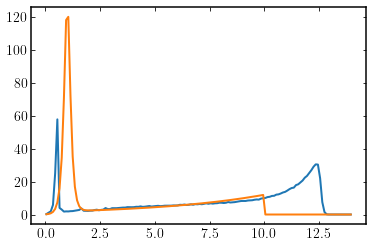

In [171]:
# a test run with random parameters
predict_sfh = psb_wild2020(model_ages, 10, 5, 1, 100, 100, 0.5, 11)
plt.plot(model_ages, model_sfh)
plt.plot(model_ages, predict_sfh)

In [172]:
# using scipy curve fit to get a fit to the true SFH
popt,pcov = scipy.optimize.curve_fit(psb_wild2020, model_ages, model_sfh, 
                                     bounds=([10,1,0,10,10,0,10],[13,10,2,1000,1000,1,12]))

In [253]:
# best fits
popt

array([1.26818189e+01, 4.18757126e+00, 5.49999954e-01, 1.93479148e+02,
       4.59486377e+02, 8.99312201e-02, 1.10132437e+01])

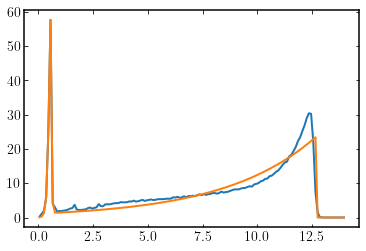

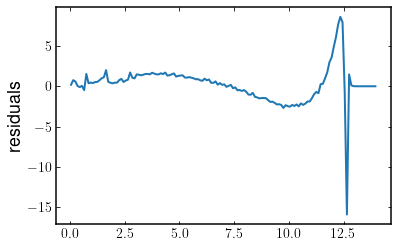

In [174]:
predict_sfh = psb_wild2020(model_ages, *popt)
plt.plot(model_ages, model_sfh)
plt.plot(model_ages, predict_sfh)
plt.show()
plt.plot(model_ages, model_sfh-predict_sfh)
plt.ylabel('residuals')
plt.show()

Turns out that the burst can be very well modelled with a double power law, however the older population does not. It almost looks like a steeper exponential decay model at first, with a linear decline element added afterwards. Ofc course another area of discrapancy is that the increase in SFR is not instataneous as suggested by an exponential decay model. This change from the true SFH to the best fit psb2 SFH should take care of some of the model-data discrapancies.

## Step 2: generate the spectrum from best fit

In [175]:
# load in true spectrum
spectrum = np.loadtxt(fname="../Yirui_test_cube/snap119/with_PSF/with_dust/Spectrum_2xSc_07_EC_BH_vw1e4_ReposNoRFBNoRP_with_PSF_with_dust_SNR15.csv", delimiter=',', skiprows=1)
spectrum[:,1] = spectrum[:,1]*10**-16
wavelengths = spectrum[:,0]

In [182]:
# non-sfh parameters based on posterior mean of run yirui_test_snap119_veldisp_off_SNR15_bin_by_1 
# (read off of corner plot)
psb = {}
psb['massformed'] = popt[-1]
psb['metallicity'] = 0.24
psb['age'] = popt[0]
psb['tau'] = popt[1]
psb['burstage'] = popt[2]
psb['alpha'] = popt[3]
psb['beta'] = popt[4]
psb['fburst'] = popt[5]

dust = {}
dust["type"] = "CF00"
dust["eta"] = 2.
dust["Av"] = 0.51
dust["n"] = 0.35

#nebular = {}
#nebular["logU"] = -3.

model_components = {}
model_components['psb_wild2020'] = psb
model_components['dust'] = dust
# not putting nebular in cause it creates emission lines that are otherwise not there in the true spectrum
#model_components['nebular'] = nebular
model_components['t_bc'] = 0.01
model_components['redshift'] = 0.04

best_fit_model = pipes.model_galaxy(model_components, spec_wavs=wavelengths)

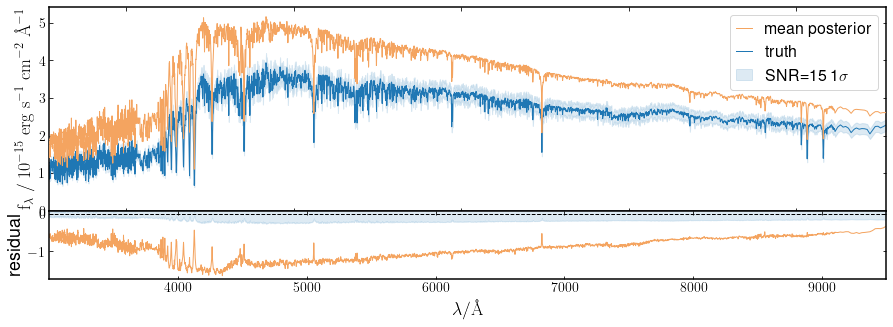

In [183]:
def plot_spec(wavelengths, true_spec, model_spec, limit_to_9500=False):
    if limit_to_9500:
        to_ind = [wavelengths<9500]
        wavelengths = wavelengths[to_ind]
        true_spec = true_spec[to_ind]
        model_spec = model_spec[to_ind]
    fig = plt.figure(figsize=[15,5])
    gs = fig.add_gridspec(4,1, hspace=0, wspace=0)
    ax1 = plt.subplot(gs[:-1])
    ax2 = plt.subplot(gs[-1])

    y_scale = pipes.plotting.add_spectrum(model_spec, ax1, label='mean posterior', lw=1)
    ax1.plot(wavelengths, true_spec[:,1]*10**-y_scale, label='truth', lw=1)
    ax1.fill_between(wavelengths, true_spec[:,1]*10**-y_scale-true_spec[:,1]*10**-y_scale/15, 
                     true_spec[:,1]*10**-y_scale+true_spec[:,1]*10**-y_scale/15,
                    color='C0', alpha=0.15, zorder=-1, label=r'SNR=15 1$\sigma$')
    ax1.legend()

    ax2.axhline(0, color="black", ls="--", lw=1)
    ax2.plot(wavelengths, (true_spec[:,1] - model_spec[:,1])*10**-y_scale, color='sandybrown', lw=1)
    ylims = ax2.get_ylim()
    ax2.fill_between(wavelengths, -true_spec[:,1]*10**-y_scale/15, true_spec[:,1]*10**-y_scale/15,
                    color='C0', alpha=0.15, zorder=-1, label=r'SNR=15 1$\sigma$')
    ax2.set_xlim(ax1.get_xlim())
    ax2.set_ylim(ylims)
    ax2.set_xlabel("$\\lambda / \\mathrm{\\AA}$")
    ax2.set_ylabel('residual')

    plt.show()
    
plot_spec(wavelengths, spectrum, best_fit_model.spectrum, limit_to_9500=True)

This generated spectrum will not be perfect, since the dust law, its parameters and many other things are likely very far from what Yirui used to create the datacube at the first place. But as long as we only check against this generated spectrum later on, we can still be self-consistant.

In [185]:
SNR = 15
spectrum_1sigma = best_fit_model.spectrum[:,1]*10**16/SNR
new_spectrum = pd.DataFrame({'observed-wave[AA]': best_fit_model.spectrum[:,0],
                             'flux[10^-16 erg/s/cm^2/AA]': best_fit_model.spectrum[:,1]*10**16,
                             'noise[10^-16 erg/s/cm^2/AA]': spectrum_1sigma})
new_spectrum.to_csv('best_fit_datacube_summed_with_dust_SNR15_no_perturbation2.csv', index=False)

Note: Originally I was not careful and did not set the R_spec in my local bagpipes to be as high as possible, so the spectrum created had bad interpolation issues in it. This created spikes when I eventually compared posterior-predicted spectra against this low-R_spec "true" spectra. Here, I show a comparison between the best fit spectrum generated with a high R_spec (orange) vs with a low R_spec (blue). They are named `best_fit_datacube_summed_with_dust_SNR15_no_perturbation2.csv` and `best_fit_datacube_summed_with_dust_SNR15_no_perturbation.csv` respectively.

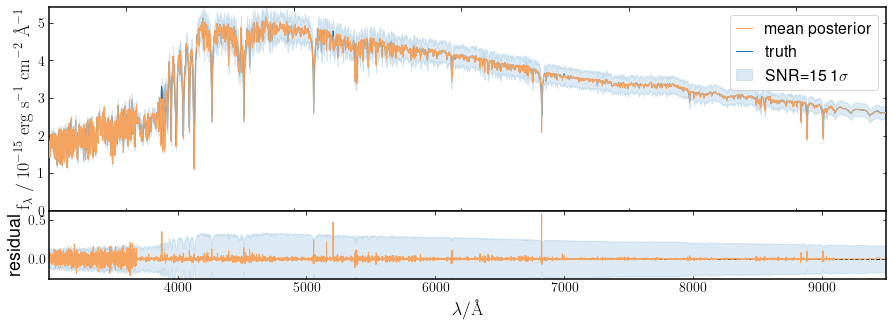

In [184]:
plot_spec(wavelengths, np.array([wavelengths,new_spectrum['flux[10^-16 erg/s/cm^2/AA]']*10**-16]).T,
          best_fit_model.spectrum, limit_to_9500=True)

the file `best_fit_datacube_summed_with_dust_SNR15_no_perturbation2.csv` is avaliable here:
https://universityofstandrews907-my.sharepoint.com/:x:/g/personal/hhl1_st-andrews_ac_uk/EUaT0KhDy0hKpaR14_wZ8ncBvCmwfBH9aAWDYTV3ggmaQw?e=dgkopA

## Step 3: fit the spectrum and analyze the results
R_spec = 1000, 1800, 3000, 4340 <br>
Note: Fits have psb2:beta as a free parameter <br>
Fitting posterior files and plots here:
https://universityofstandrews907-my.sharepoint.com/:f:/g/personal/hhl1_st-andrews_ac_uk/EmAMsNCgl-hCkOcelDVg8akBmBDSxqcKMUcvnZUsQ4rw1A?e=LnmJ7m

In [99]:
def mask_em(wave):
    """ from maskem.pro OII, Hgama, Hbeta, OIII, OIII: Vacuum """

    
    lines_vac = np.array([3727.092,3729.875,4102.892, 4341.692,4862.683,4960.295,5008.24])
    lines = pyasl.vactoair2(lines_vac)
    
    mask = []
    for i in range(lines.shape[0]):
        masksize = 5

        ind = np.where((wave>lines[i]-masksize) & (wave<lines[i]+masksize))
        mask.extend(ind[0])

    # MgII  2796.352 ,2803.531 
    #ind = np.where((wave>2766.4) & (wave<2833.5))

    # remove everything bluewards of 3000A
    ind = np.where(wave<3000)
    mask.extend(ind[0])    

    return mask

def load_uds_spectrum_mask(ID,z):

    # load spectral data
    spectrum = np.loadtxt(fname=ID+".csv", delimiter=',', skiprows=1)
    
    spectrum[:,1] *= 10**-16
    spectrum[:,2] *= 10**-16

    # blow up the errors associated with any bad points in the spectrum and photometry
    for i in range(len(spectrum)):
        if spectrum[i,1] == 0 or spectrum[i,2] <= 0:
            spectrum[i,1] = 0.
            spectrum[i,2] = 9.9*10**99.
    
    # nebular emission lines and interstellar absorption lines
    mask = mask_em(spectrum[:,0]/(1+z))
    spectrum[mask, 2] = 9.9*10**99.
    
    # O2 telluric
    mask = ((spectrum[:,0] > 7580.) & (spectrum[:,0] < 7650.))
    spectrum[mask, 2] = 9.9*10**99.

    #return bin(spectrum,4)
    return spectrum
    

def load_uds_mask(ID):
    z = 0.04
    spectrum = load_uds_spectrum_mask(ID,z)

    return spectrum

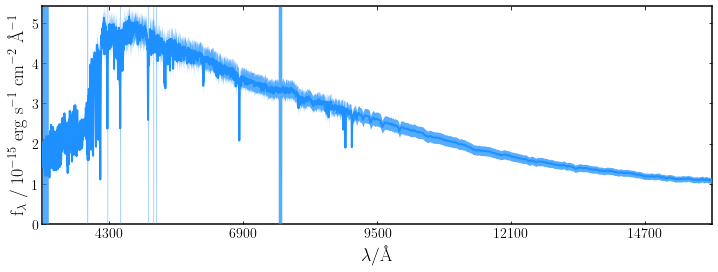

In [193]:
ID = 'best_fit_datacube_summed_with_dust_SNR15_no_perturbation2'
z = 0.04

galaxy = pipes.galaxy(ID, load_uds_mask, photometry_exists=False)

fig = galaxy.plot()

In [194]:
def plot_spec2(fit, ID, runID):
    # Make the figure
    matplotlib.rcParams.update({'font.size': 16})
    params = {'legend.fontsize': 16,
              'legend.handlelength': 1}
    matplotlib.rcParams.update(params)
    matplotlib.rcParams['text.usetex'] = True
    fit.posterior.get_advanced_quantities()

    naxes=1
    fig = plt.figure(figsize=(12, 5.*naxes))

    gs1 = matplotlib.gridspec.GridSpec(4, 1, hspace=0., wspace=0.)
    ax1 = plt.subplot(gs1[:3])
    ax3 = plt.subplot(gs1[3])

    mask = fit.galaxy.spectrum[:, 2] < 1.
    fit.galaxy.spectrum[mask, 2] = 0.

    y_scale = pipes.plotting.add_spectrum(fit.galaxy.spectrum, ax1)
    pipes.plotting.add_spectrum_posterior(fit, ax1, y_scale=y_scale)

    post_median = np.median(fit.posterior.samples["spectrum"], axis=0)

    #ax1.plot(fit.galaxy.spectrum[:,0],
    #         post_median*10**-y_scale,
    #         color="black", lw=1.0,zorder=11)

    ax3.axhline(0, color="black", ls="--", lw=1)
    ax3.plot(fit.galaxy.spectrum[:,0],(post_median - fit.galaxy.spectrum[:,1])*10**-y_scale, color="sandybrown")
    #ax1.set_xlim([3000,4200])
    ax3.set_xlim(ax1.get_xlim())
    ax3.set_xlabel("$\\lambda / \\mathrm{\\AA}$")
    ax3.set_ylabel('residual')
    fig.savefig('pipes/plots/'+runID+'/'+ID+'_fit.pdf')
    plt.show()
    
def plot_sfh(fit, model_lookbacktime, model_sfh, ID, runID):
    if 'redshift' in fit.posterior.samples.keys():
        post_z = np.median(fit.posterior.samples['redshift'])
    else: post_z = 0.04
    age_at_z = pipes.utils.cosmo.age(post_z).value

    #posterior sfh
    post_sfh = fit.posterior.samples['sfh']
    median_sfh = np.median(post_sfh,axis=0)
    age_of_universe = np.interp(post_z, pipes.utils.z_array, pipes.utils.age_at_z)
    post_ages = age_of_universe - fit.posterior.sfh.ages*10**-9
    post_m_total = np.trapz(y=median_sfh[::-1], x=post_ages[::-1])

    #model sfh
    model_sfh = model_sfh.copy()
    model_ages = age_at_z-model_lookbacktime.copy()
    model_m_total = np.trapz(y=model_sfh[::-1], x=model_ages[::-1])

    fig, ax = plt.subplots(1,1, figsize=[15,5])
    pipes.plotting.add_sfh_posterior(fit, ax)
    ax.plot(model_ages, model_sfh)#/(model_m_total/post_m_total))
    ylim = ax.get_ylim()

    #calculate model burst fraction
    model_f_burst = popt[5]
    model_t_burst = age_at_z-popt[2]
    print('model f_burst and t_burst:',model_f_burst,model_t_burst)
    ax.vlines(model_t_burst, 0, ylim[1], color='red', ls='--')
    ax.arrow(age_at_z,ylim[1]*0.8,-(age_at_z-model_t_burst),0.0,color='red',head_width=np.max(ylim)/20., 
             head_length=0.1,length_includes_head=True)

    #use psb2's built in fburst and tburst posteriors to plot arrows
    post_f_burst = np.percentile(fit.posterior.samples['psb2:fburst'], (16,50,84))
    post_t_burst = age_of_universe-np.percentile(fit.posterior.samples['psb2:burstage'], (84,50,16))

    print('posterior f_burst and t_burst:',post_f_burst,post_t_burst)
    ax.vlines(post_t_burst[1], 0, ylim[1], color='sandybrown', ls='--')
    ax.arrow(age_of_universe,ylim[1]*0.9,-(age_of_universe-post_t_burst[1]),0.0,color='sandybrown',
             head_width=np.max(ylim)/20., head_length=0.1,length_includes_head=True)

    ax.set_ylim(ylim)
    #add text about z, age at z, poster f_burst and t_burst
    f_burst_r = [np.round(post_f_burst[1],2),np.round(post_f_burst[2]-post_f_burst[1],2),np.round(post_f_burst[1]-post_f_burst[0],2)]
    f_burst_text = f'post f\_burst={f_burst_r[0]}+{f_burst_r[1]}-{f_burst_r[2]}\n '
    t_burst_r = [np.round(post_t_burst[1],2),np.round(post_t_burst[2]-post_t_burst[1],2),np.round(post_t_burst[1]-post_t_burst[0],2)]
    t_burst_text = f'post t\_burst={t_burst_r[0]}+{t_burst_r[1]}-{t_burst_r[2]}Gyr \n '
    ax.text(0.7,0.6,
            f'redshift={np.round(post_z,3)}\n ' + 
            f'age at z={np.round(age_at_z,2)}Gyr\n ' + 
            f_burst_text + 
            f'true f\_burst={np.round(model_f_burst,2)}\n ' +
            t_burst_text +
            f'true t\_burst={np.round(model_t_burst,2)}Gyr',
            fontsize=14, transform=ax.transAxes, bbox=dict(boxstyle='round', facecolor='white'))
    #ax.set_yscale('log')
    fig.savefig('pipes/plots/'+runID+'/'+ID+'_combined_sfh.pdf')
    plt.show()
    
def make_plots(galaxy, ID, runID, model_ages, predict_sfh):
    fit = pipes.fit(galaxy, {}, run=runID)
    plot_spec2(fit, ID, runID)
    fig = fit.plot_sfh_posterior(save=True, show=True)
    fig = fit.plot_corner(save=True, show=True)
    plot_sfh(fit, model_ages, predict_sfh, ID, runID)


Results loaded from pipes/posterior/outshining_internally_consistant_test_Rspec1000_2/best_fit_datacube_summed_with_dust_SNR15_no_perturbation2.h5



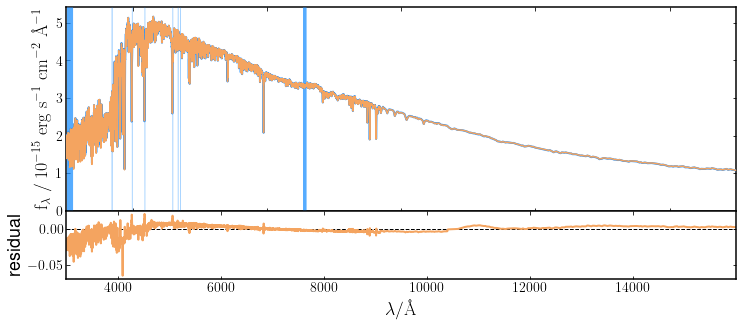

model f_burst and t_burst: 0.08993122012854099 12.374096886264331
posterior f_burst and t_burst: [0.0872803  0.09331888 0.10481962] [12.38868685 12.4272198  12.46155146]


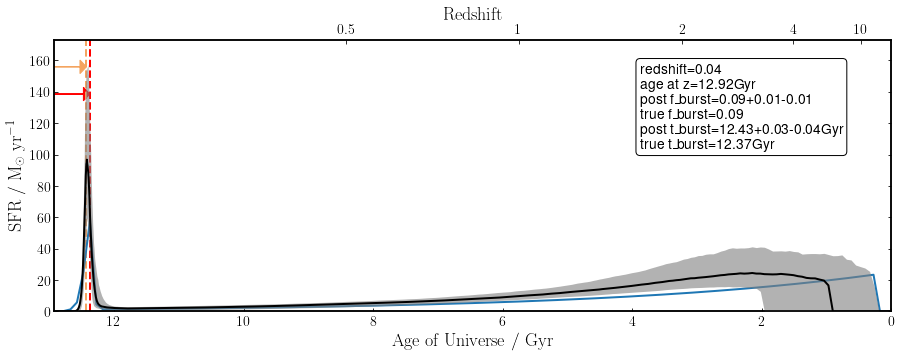

In [195]:
make_plots(galaxy, ID, "outshining_internally_consistant_test_Rspec1000_2", model_ages, predict_sfh)


Results loaded from pipes/posterior/outshining_internally_consistant_test_Rspec1800_2/best_fit_datacube_summed_with_dust_SNR15_no_perturbation2.h5



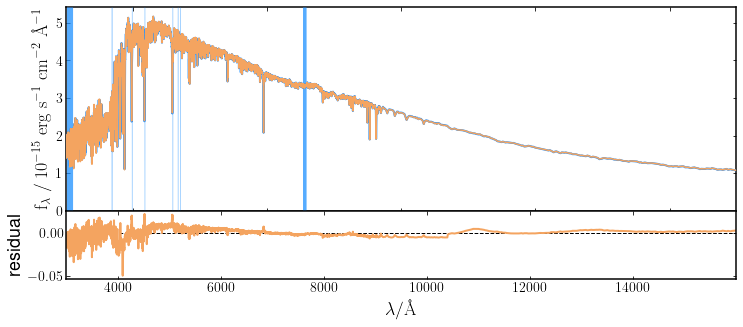

model f_burst and t_burst: 0.08993122012854099 12.374073119234653
posterior f_burst and t_burst: [0.08456666 0.08996376 0.09871228] [12.38610635 12.43035996 12.46814178]


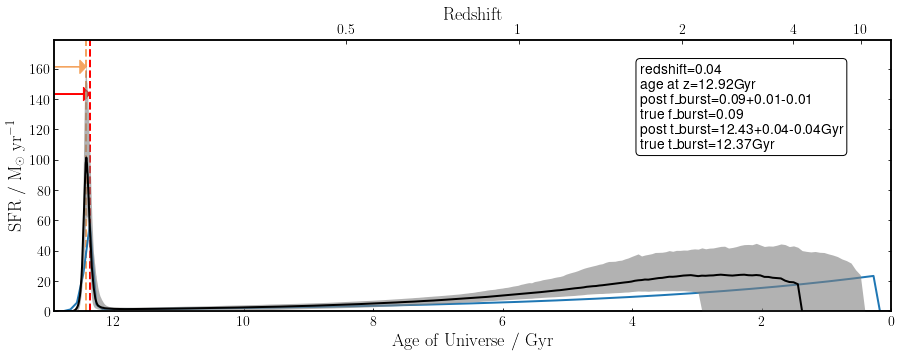

In [196]:
make_plots(galaxy, ID, "outshining_internally_consistant_test_Rspec1800_2", model_ages, predict_sfh)


Results loaded from pipes/posterior/outshining_internally_consistant_test_Rspec3000_2/best_fit_datacube_summed_with_dust_SNR15_no_perturbation2.h5



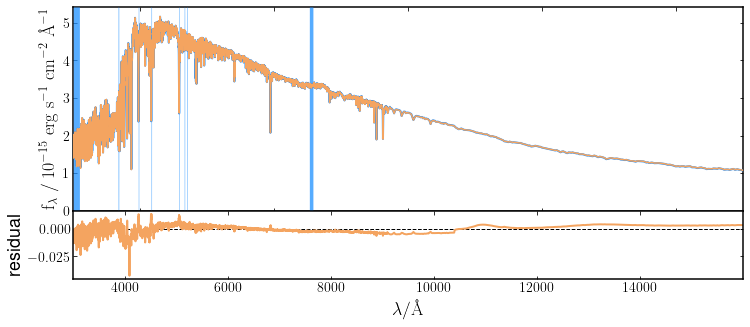

model f_burst and t_burst: 0.08993122012854099 12.374070762620653
posterior f_burst and t_burst: [0.08379281 0.08959223 0.09825889] [12.39342469 12.44675164 12.48158197]


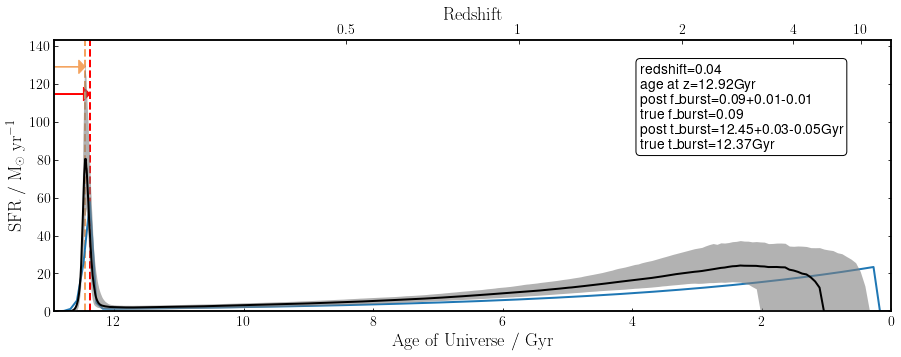

In [197]:
make_plots(galaxy, ID, "outshining_internally_consistant_test_Rspec3000_2", model_ages, predict_sfh)


Results loaded from pipes/posterior/outshining_internally_consistant_test_Rspec4340_2/best_fit_datacube_summed_with_dust_SNR15_no_perturbation2.h5



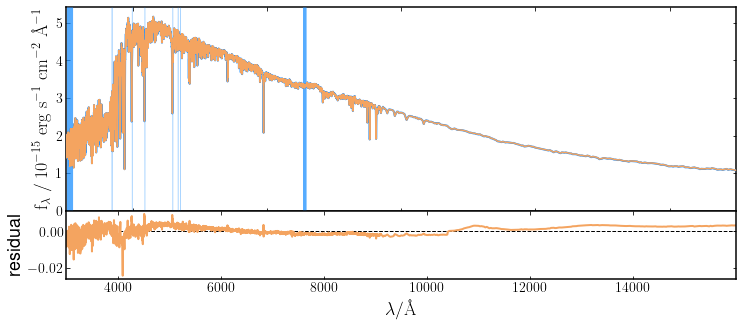

model f_burst and t_burst: 0.08993122012854099 12.374058721732808
posterior f_burst and t_burst: [0.0851778  0.09276349 0.10507065] [12.38452587 12.45341767 12.49819665]


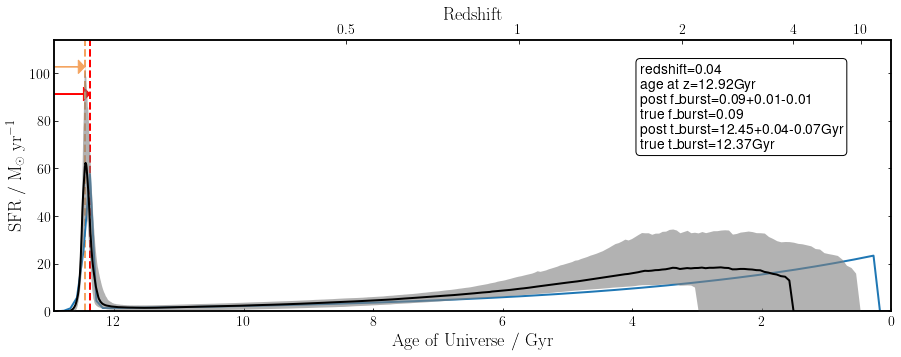

In [198]:
make_plots(galaxy, ID, "outshining_internally_consistant_test_Rspec4340_2", model_ages, predict_sfh)

### Comments:
1. With the help of a spectrum from something that can be directly generated by bagpipes with a uniform metallicity and from a parametric SFH, the posterior SFHs are able to reach much further into the ancient past and have median values of the beginning of the old population be as early as <2 Gyr of age of universe. This potentially points towards that combatting outshining, at least to this extent, is possible if there is this little model-data mismatch.
2. However, even though this improved things, the true beginning formation of the older population still sits >1 sigma of credible intervals away from the median, meaning there is still definite bias towards being outshined.
3. Fits of all R_spec values predicted very accurate fburst values, however, only R_spec=4340 run predicts a starburst SFR peak that is comparable with the model truth, while the truth lies more than 1 sigma away from estimations of the peak SFR for all other fits. I think this points to more accurate estimations of alpha and beta for the starburst with higher R_spec, espeically alpha, since alpha seems to be over-estimation for the first 3 fits (decays too fast).

## Step 4: compare spectra predicted from these posteriors against the spectrum in step 2

In [204]:
def make_model_components(Av, n, age, tau, massformed, metallicity, burstage, alpha, beta, fburst, redshift):
    dust = {}
    dust["type"] = "CF00"
    dust["eta"] = 2.
    dust["Av"] = Av
    dust["n"] = n

    #nebular = {}
    #nebular["logU"] = -3.

    psb2 = {}
    psb2["age"] = age                     # Vary age between 4 Myr and 14 Gyr. In practice 
                                          # the code automatically limits this to the age of
                                          # the Universe at the observed redshift.
    psb2["tau"] = tau                   # Vary tau between 300 Myr and 10 Gyr
    psb2["massformed"] = massformed              # vary log_10(M*/M_solar) between 1 and 15
    psb2["metallicity"] = metallicity           # vary Z between 0.1 and 2.5 Z_solar

    psb2["burstage"] = burstage                   # age of burst from 0 to 2Gyr
    psb2["alpha"] = alpha              # decline of burst
    psb2["beta"] = beta                    # rise of burst: fixed
    psb2["fburst"] = fburst

    model_components = {}
    model_components['psb_wild2020'] = psb2
    model_components['dust'] = dust
    #model_components['nebular'] = nebular
    model_components['t_bc'] = 0.01
    model_components['redshift'] = redshift
    return model_components

def limit_and_plot(median_spectrum, samp_spectra, true_spec, wavelengths, limits=None):
    if limits is not None:
        to_ind = (limits[0]<wavelengths)*(wavelengths<limits[1])
    else:
        to_ind = [wavelengths<9500]
    wavelengths = wavelengths[to_ind]
    median_spectrum = median_spectrum[to_ind]
    true_spec = true_spec[to_ind]
    for i in range(len(samp_spectra)):
        samp_spectra[i] = samp_spectra[i][to_ind]
        
    # the residual comparison plot
    fig = plt.figure(figsize=[15,15])
    gs = fig.add_gridspec(2,1, hspace=0)
    ax1 = plt.subplot(gs[0])
    ax2 = plt.subplot(gs[1])
    
    y_scale = pipes.plotting.add_spectrum(median_spectrum, ax1, 
                                          label='median posterior', lw=1, color='sandybrown')
    ax1.plot(wavelengths, true_spec[:,1]*10**-y_scale, label='truth', lw=1)
    for samp_spec in samp_spectra:
        pipes.plotting.add_spectrum(samp_spec, ax1, lw=1, color='k', alpha=0.1)
    ax1.legend()
    if limits is not None:
        ax1.set_xlim(limits)

    ax2.axhline(0, color="black", ls="--", lw=1)
    ax2.plot(wavelengths, (true_spec[:,1] - median_spectrum[:,1])*10**-y_scale, 
             label='median posterior', lw=1, color='sandybrown')
    for samp_spec in samp_spectra:
        ax2.plot(wavelengths, (true_spec[:,1] - samp_spec[:,1])*10**-y_scale, 
                 lw=1, color='k', alpha=0.1)
    ax2.set_xlim(ax1.get_xlim())
    ax2.set_xlabel("$\\lambda / \\mathrm{\\AA}$")
    ax2.set_ylabel('residual')

    plt.show()

def compare_posterior_with_truth(runID):
    keys = ['dust:Av', 'dust:n', 'psb2:age', 'psb2:tau', 'psb2:massformed', 'psb2:metallicity', 
            'psb2:burstage', 'psb2:alpha', 'psb2:beta', 'psb2:fburst', 'redshift']
    fit = pipes.fit(galaxy, {}, run=runID)
    # take out 10 samples and median posteriors from the fits
    medians = []
    for key in keys:
        medians.append(np.median(fit.posterior.samples[key]))
    median_model = pipes.model_galaxy(make_model_components(*medians), spec_wavs=wavelengths)
    median_spectrum = median_model.spectrum

    samp_len = len(fit.posterior.samples['psb2:age'])
    samp_ind = np.random.randint(samp_len, size=10)
    samps = []
    samp_spectra = []
    for i,ind in enumerate(samp_ind):
        sample_vals = []
        for key in keys:
            sample_vals.append(fit.posterior.samples[key][ind])
        samps.append(sample_vals)
        samp_model = pipes.model_galaxy(make_model_components(*sample_vals), spec_wavs=wavelengths)
        samp_spectra.append(samp_model.spectrum)
    
    limit_and_plot(median_spectrum.copy(), samp_spectra.copy(), best_fit_model.spectrum.copy(), wavelengths.copy())
    limit_and_plot(median_spectrum.copy(), samp_spectra.copy(), best_fit_model.spectrum.copy(), wavelengths.copy(),
                   limits=[3700,4200])
    limit_and_plot(median_spectrum.copy(), samp_spectra.copy(), best_fit_model.spectrum.copy(), wavelengths.copy(),
                   limits=[6600,7100])


Results loaded from pipes/posterior/outshining_internally_consistant_test_Rspec1000_2/best_fit_datacube_summed_with_dust_SNR15_no_perturbation2.h5



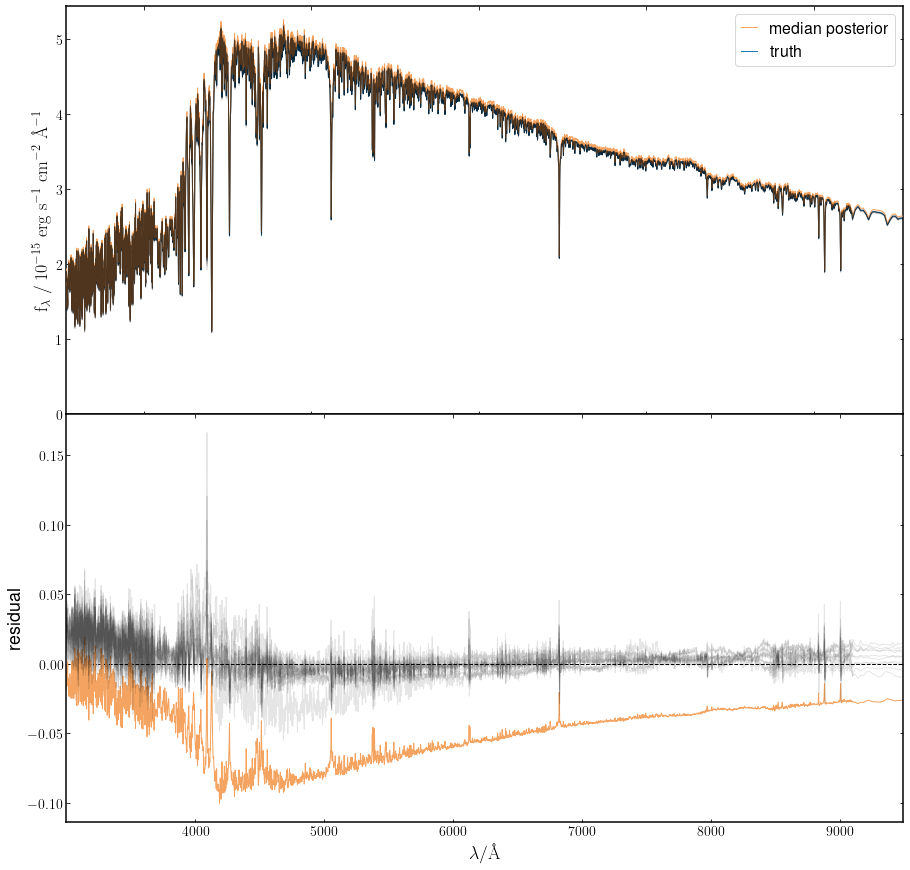

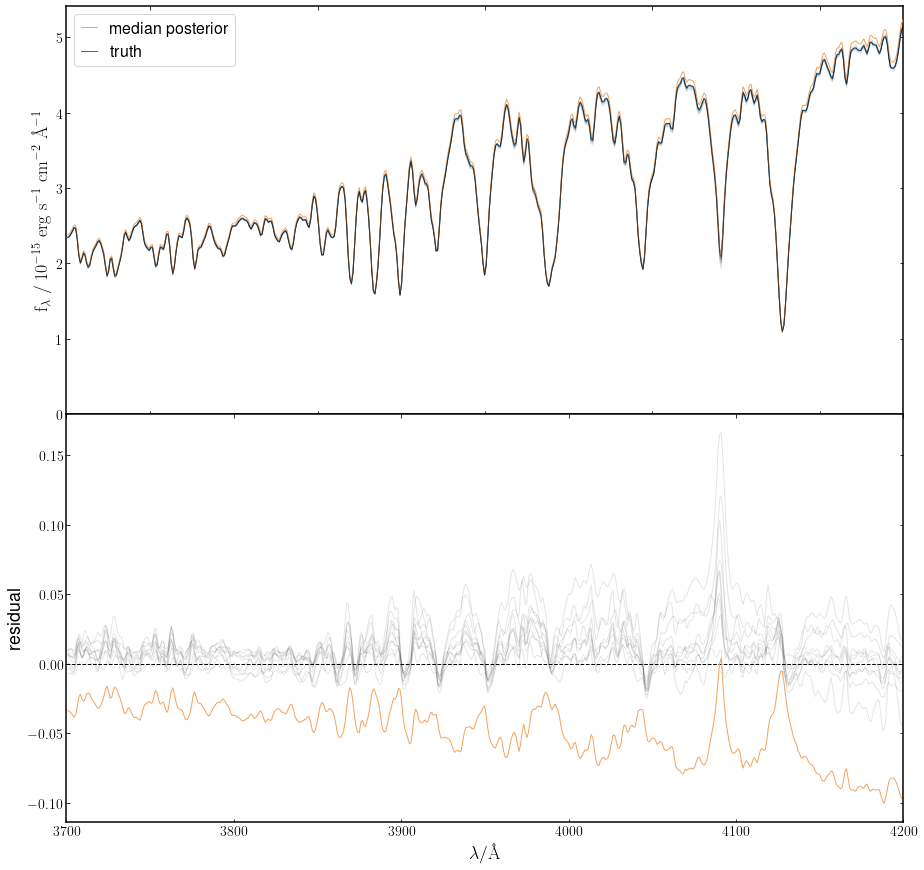

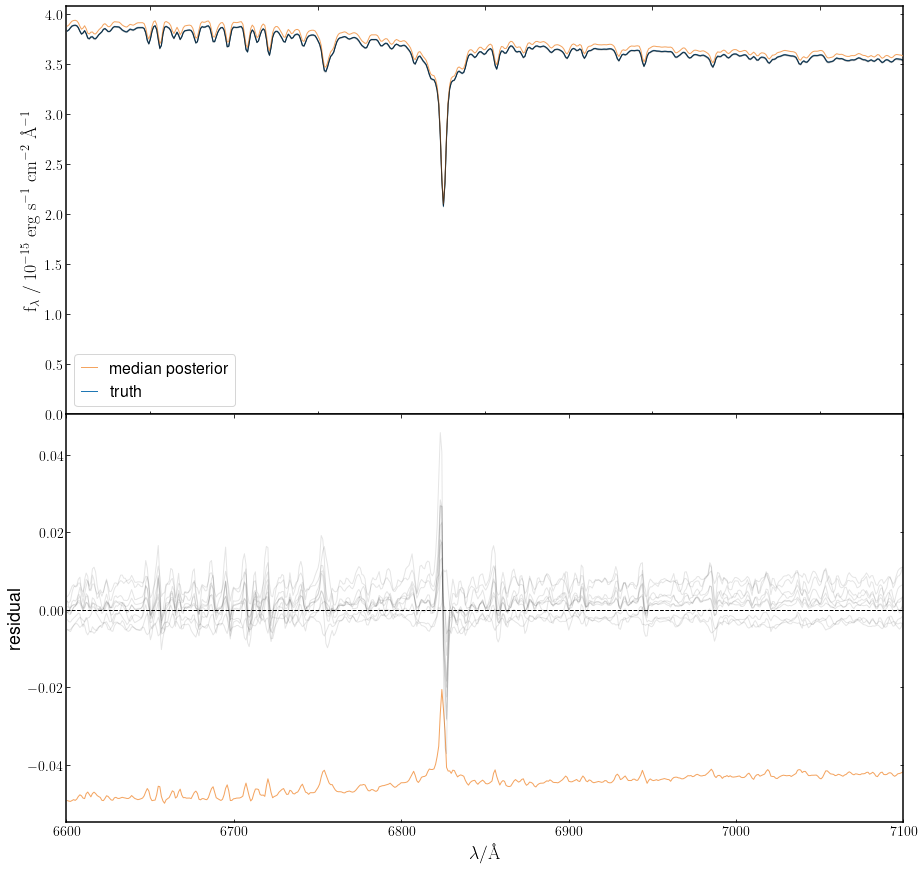

In [205]:
compare_posterior_with_truth("outshining_internally_consistant_test_Rspec1000_2")


Results loaded from pipes/posterior/outshining_internally_consistant_test_Rspec1800_2/best_fit_datacube_summed_with_dust_SNR15_no_perturbation2.h5



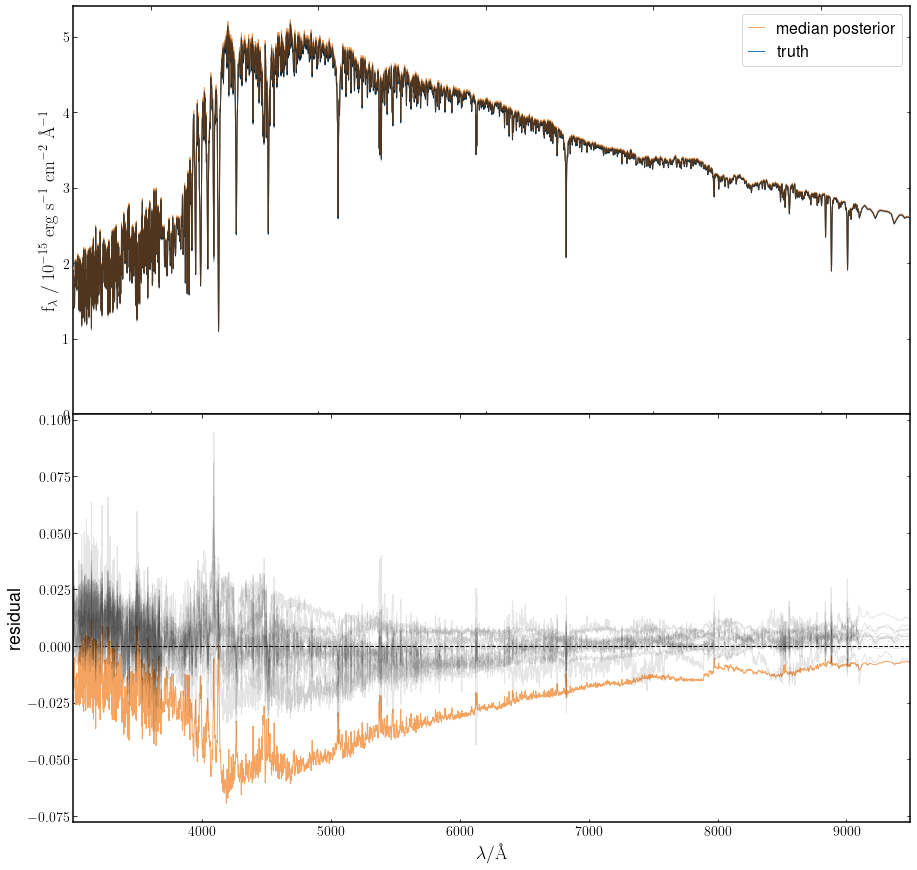

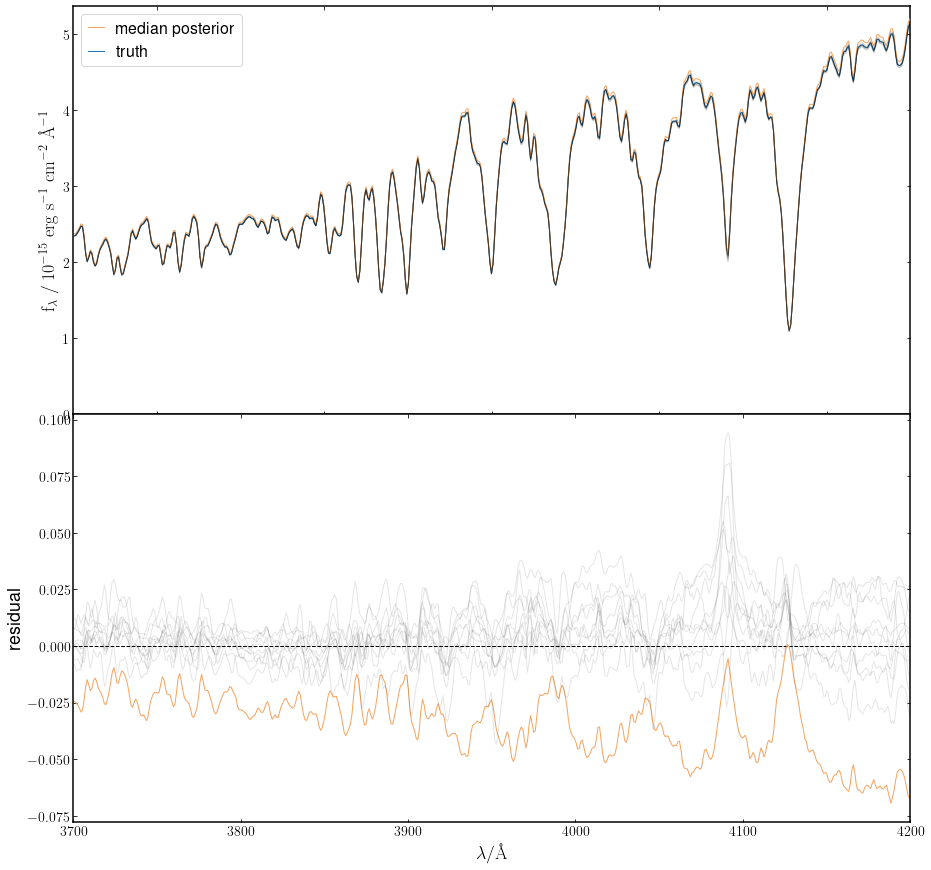

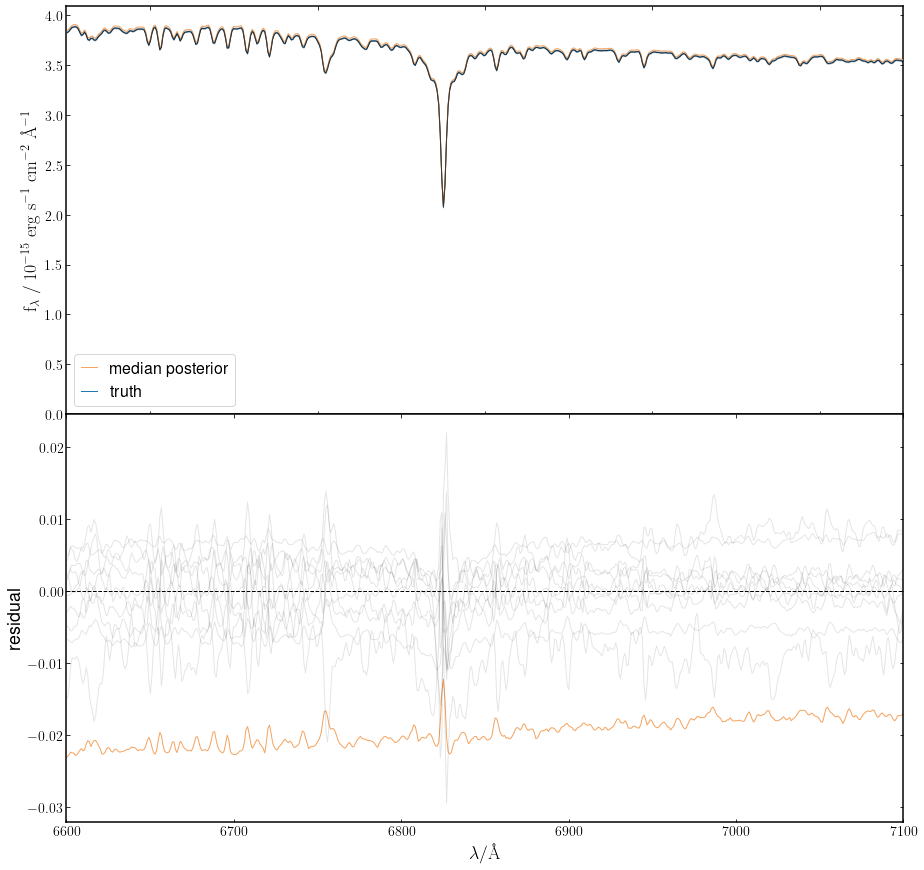

In [206]:
compare_posterior_with_truth("outshining_internally_consistant_test_Rspec1800_2")


Results loaded from pipes/posterior/outshining_internally_consistant_test_Rspec3000_2/best_fit_datacube_summed_with_dust_SNR15_no_perturbation2.h5



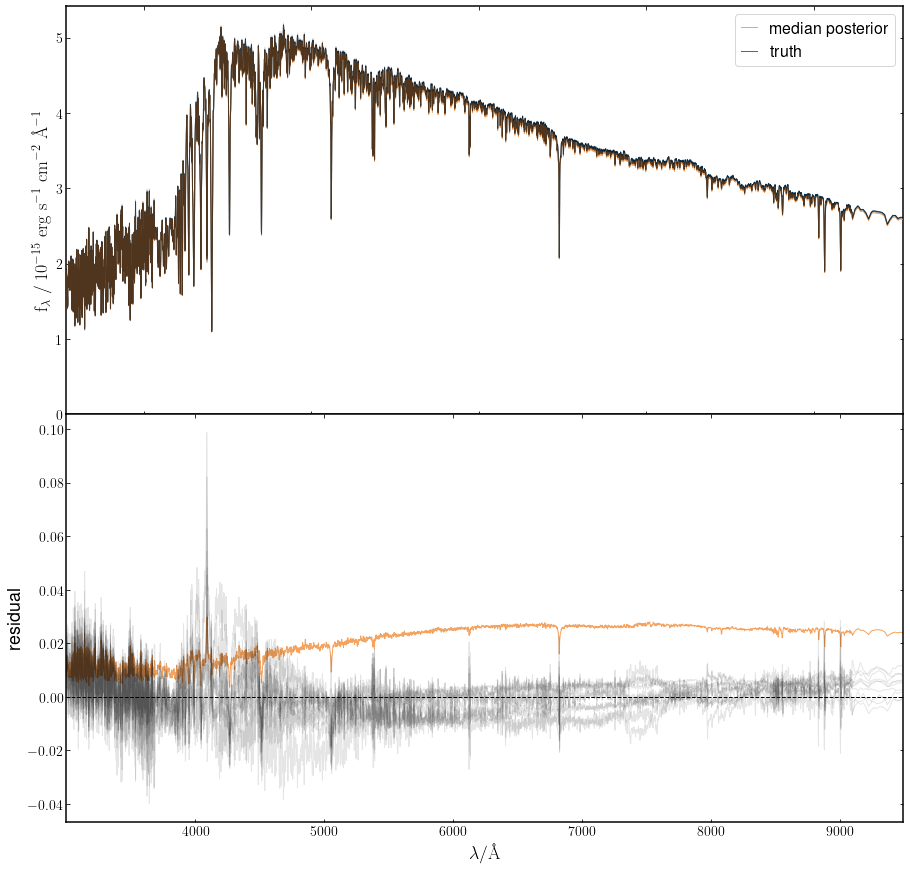

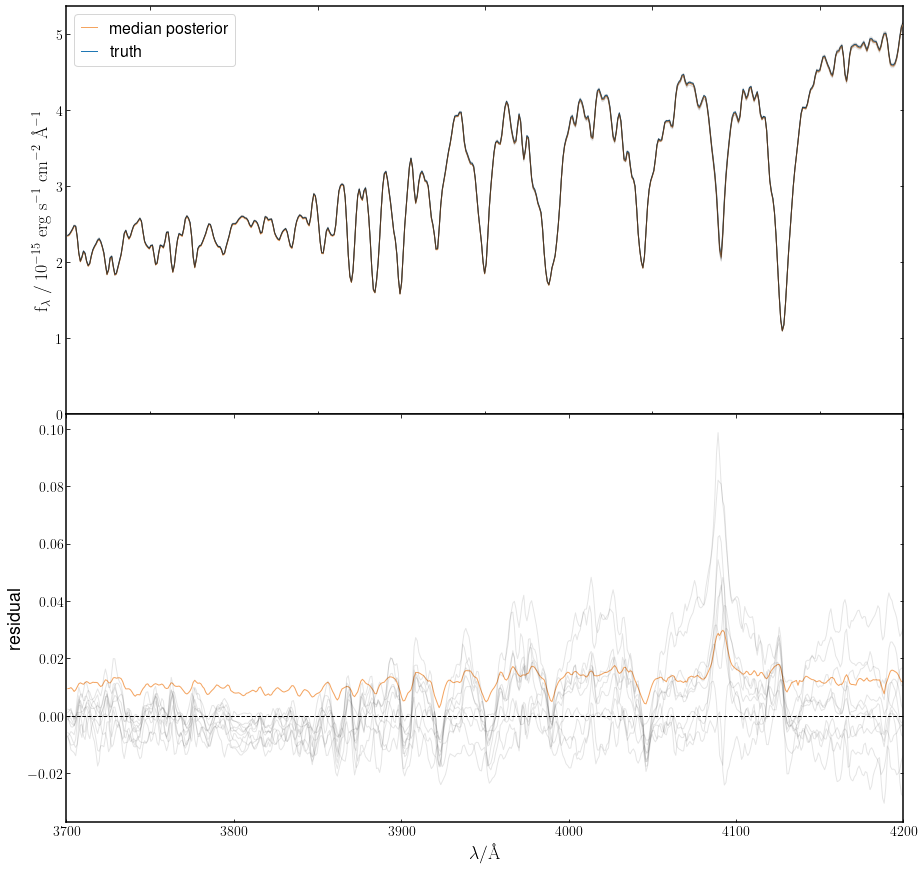

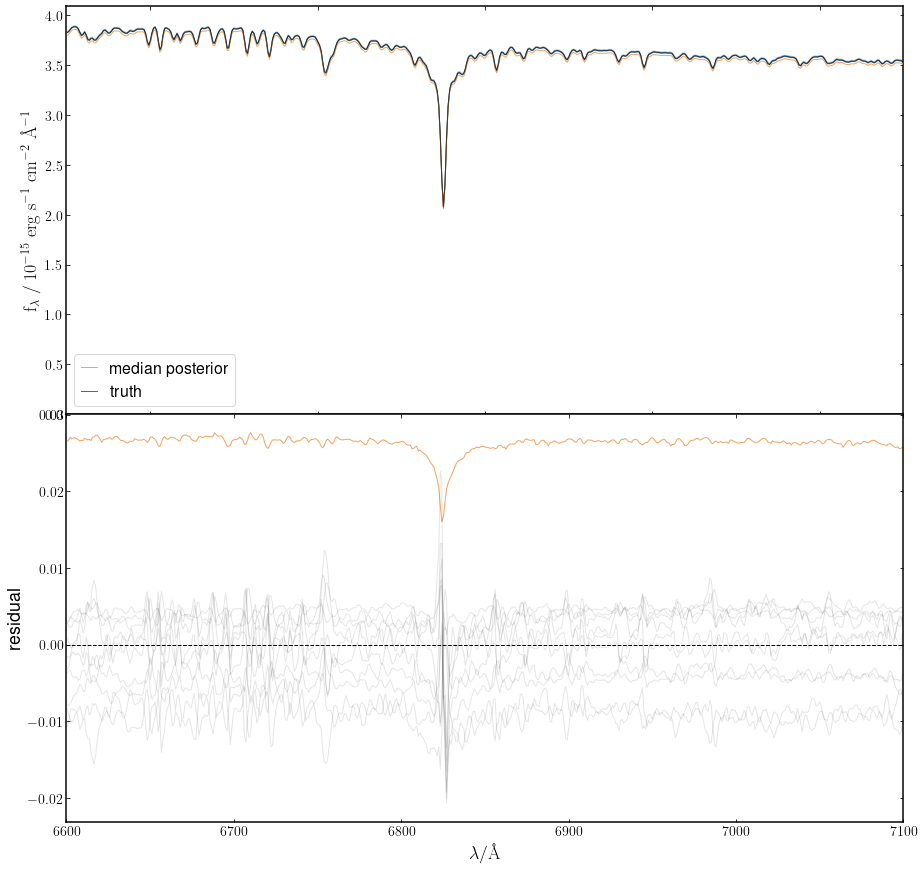

In [207]:
compare_posterior_with_truth("outshining_internally_consistant_test_Rspec3000_2")


Results loaded from pipes/posterior/outshining_internally_consistant_test_Rspec4340_2/best_fit_datacube_summed_with_dust_SNR15_no_perturbation2.h5



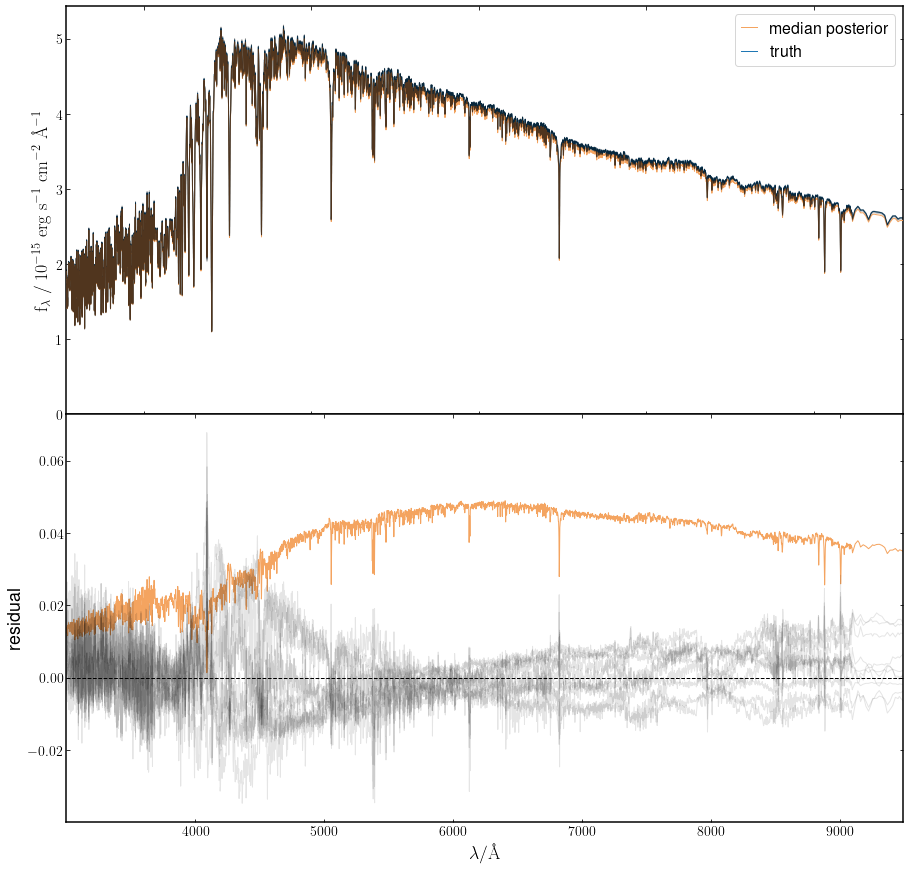

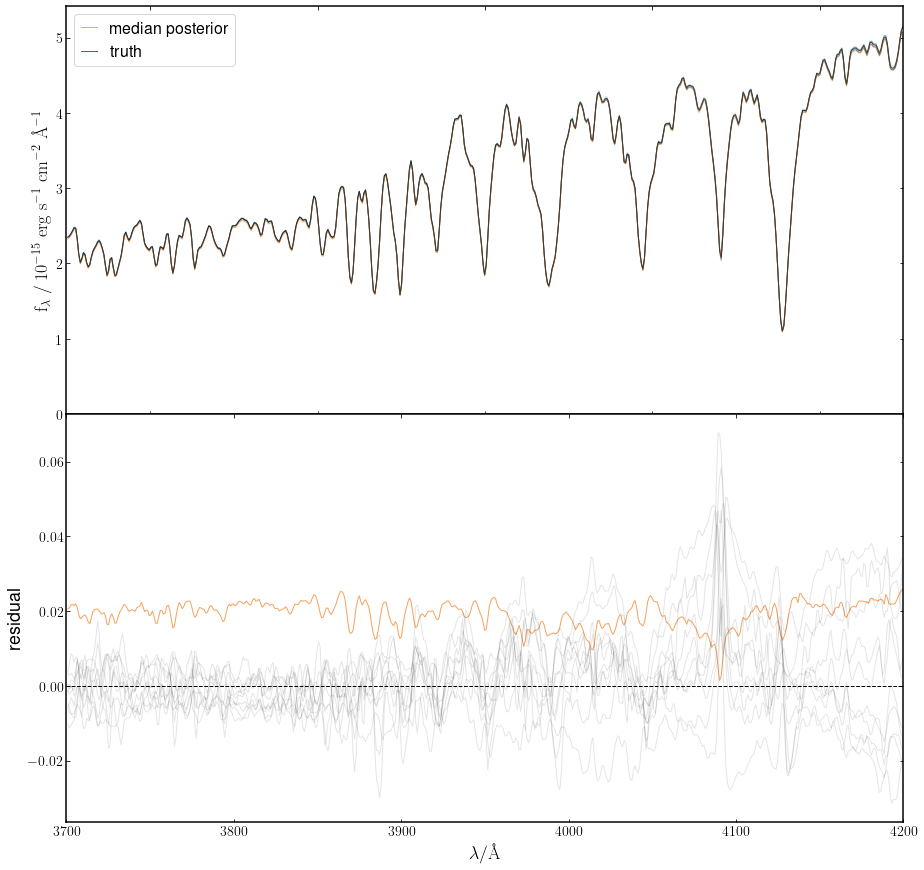

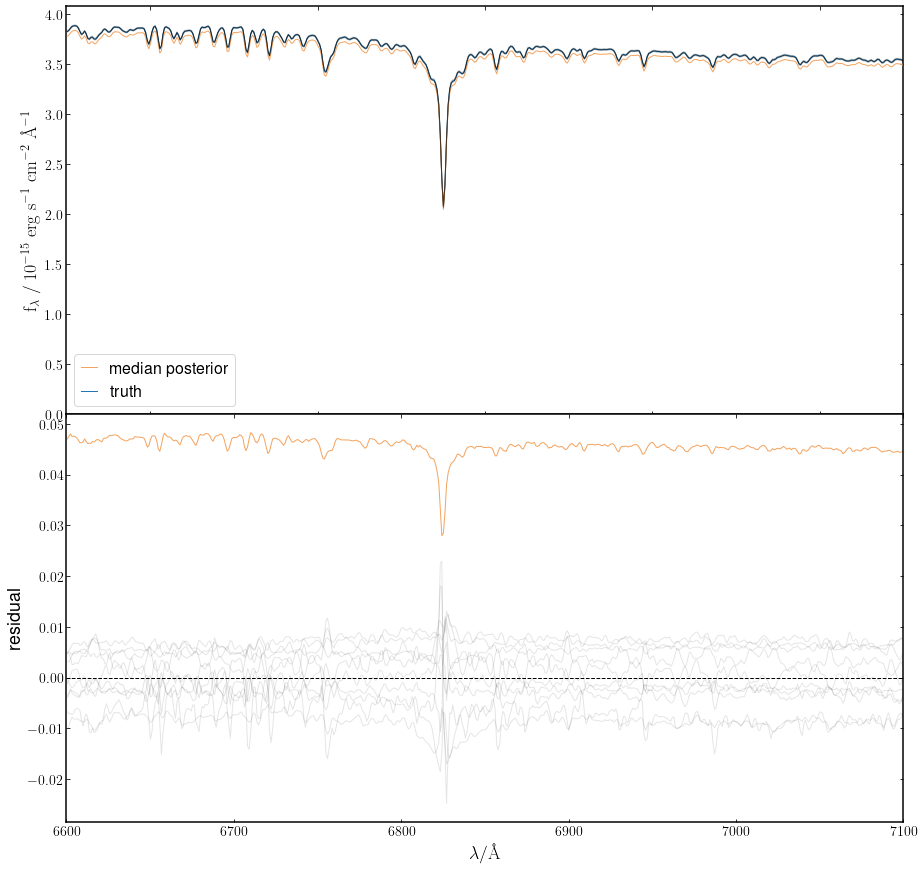

In [208]:
compare_posterior_with_truth("outshining_internally_consistant_test_Rspec4340_2")

#### Comments:
1. With the usage of a super high R_spec spectrum to generate the data to be fitted, and also the usage of bagpipes to generate the spectrum from the same SFH functional forms and dust laws, the residual feature at ~3920 is no longer prominent.
2. However, single absorption lines like the one at ~6820 seem to exhibit "spike up and spike down" shapes, an indication of disagreement between the true spectrum and fitted spectrums in terms of redshift, shifting the fitted spectrum around in wavelength.
3. The magnitude of this spike at ~6820 seems to slightly decrease with increasing fitting R_spec

## Bonus: compare posterior estimations against best fit with violin plots

In [249]:
def violin_plot(truth_val, dist_df, ax):
    sns.violinplot(x='xval',y='postdist', ax=ax, data=dist_df)
    x_vals = dist_df['xval'].unique()
    ax.plot(np.arange(len(x_vals)), [truth_val]*len(x_vals), 'k--', alpha=0.5)
    ax.scatter(np.arange(len(x_vals)), [truth_val]*len(x_vals), color='k', marker='x', s=100, zorder=5, label='truths')
    
def get_post_dists(runID):
    keys = ['dust:Av', 'dust:n', 'psb2:age', 'psb2:tau', 'psb2:massformed', 'psb2:metallicity', 
            'psb2:burstage', 'psb2:alpha', 'psb2:beta', 'psb2:fburst', 'redshift']
    fit = pipes.fit(galaxy, {}, run=runID)
    dists = {}
    for key in keys:
        dists[key] = fit.posterior.samples[key]
    return dists

def all_violin_plot():
    dists1000 = get_post_dists("outshining_internally_consistant_test_Rspec1000_2")
    dists1800 = get_post_dists("outshining_internally_consistant_test_Rspec1800_2")
    dists3000 = get_post_dists("outshining_internally_consistant_test_Rspec3000_2")
    dists4340 = get_post_dists("outshining_internally_consistant_test_Rspec4340_2")
    keys = dists1000.keys()
    truth_vals = {'dust:Av':0.51, 'dust:n':0.35, 'psb2:age':popt[0], 'psb2:tau':popt[1], 
                  'psb2:massformed':popt[-1], 'psb2:metallicity':0.24, 'psb2:burstage':popt[2], 
                  'psb2:alpha':popt[3], 'psb2:beta':popt[4], 'psb2:fburst':popt[5], 'redshift':0.04}
    for key in keys:
        individual_dfs = []
        R_specs = [1000, 1800, 3000, 4340]
        for i, post_dist in enumerate([dists1000, dists1800, dists3000, dists4340]):
            individual_dfs.append(pd.DataFrame({'xval':[R_specs[i]]*len(post_dist[key]), 'postdist':post_dist[key]}))
        combined_df = pd.concat(individual_dfs)
        fig,ax = plt.subplots(1,1, figsize=[8,8])
        violin_plot(truth_vals[key], combined_df, ax)
        ax.set_xlabel('R\_spec')
        ax.set_ylabel(key)
        ax.legend()
        plt.show()


Results loaded from pipes/posterior/outshining_internally_consistant_test_Rspec1000_2/best_fit_datacube_summed_with_dust_SNR15_no_perturbation2.h5


Results loaded from pipes/posterior/outshining_internally_consistant_test_Rspec1800_2/best_fit_datacube_summed_with_dust_SNR15_no_perturbation2.h5


Results loaded from pipes/posterior/outshining_internally_consistant_test_Rspec3000_2/best_fit_datacube_summed_with_dust_SNR15_no_perturbation2.h5


Results loaded from pipes/posterior/outshining_internally_consistant_test_Rspec4340_2/best_fit_datacube_summed_with_dust_SNR15_no_perturbation2.h5



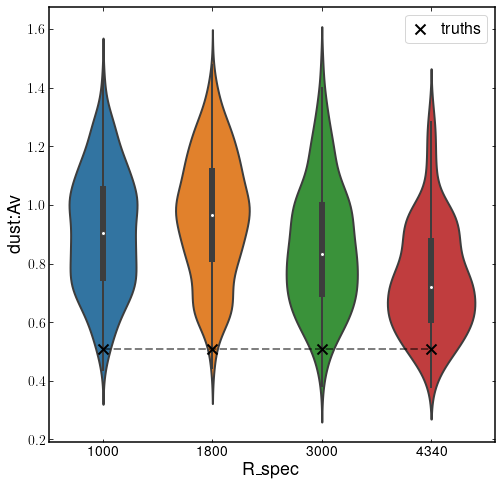

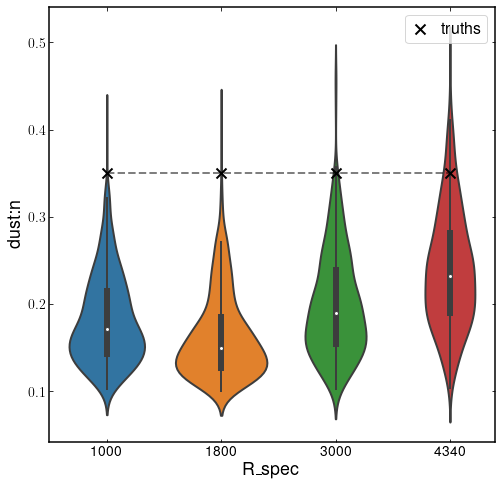

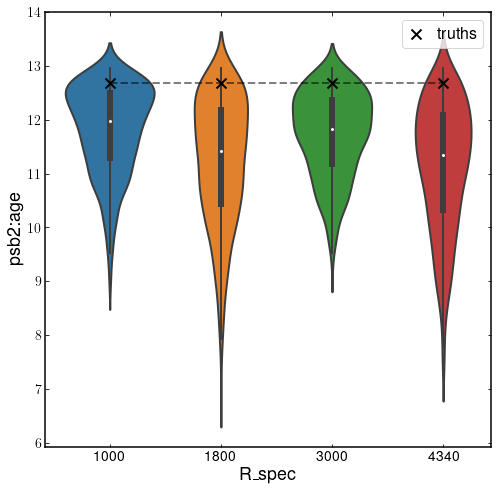

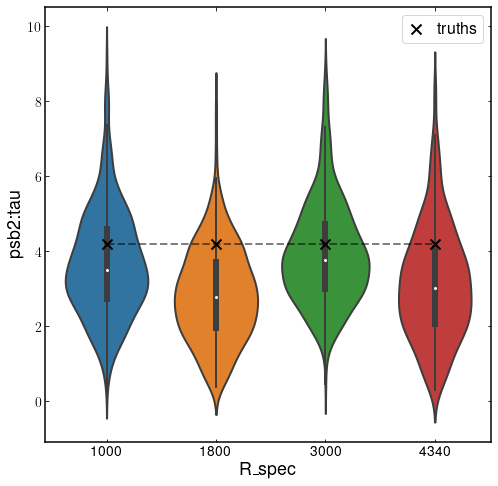

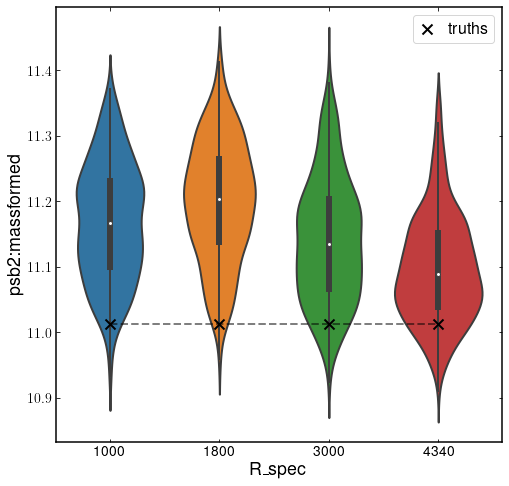

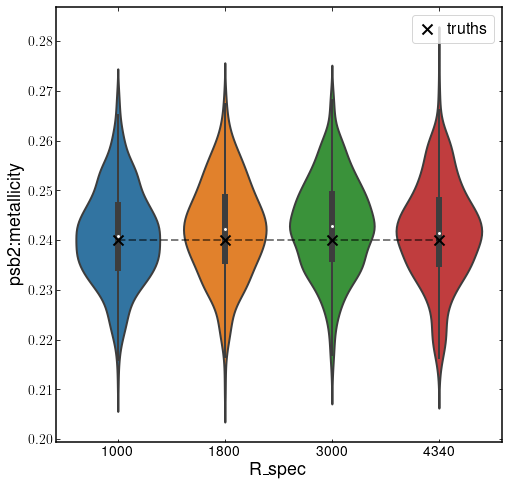

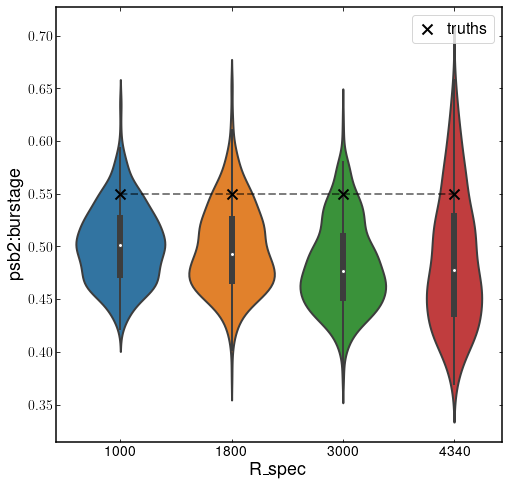

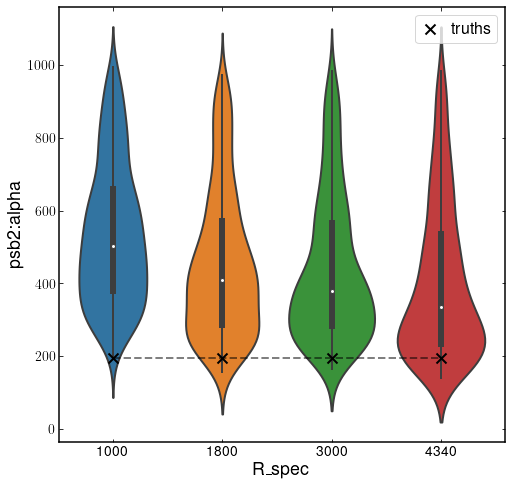

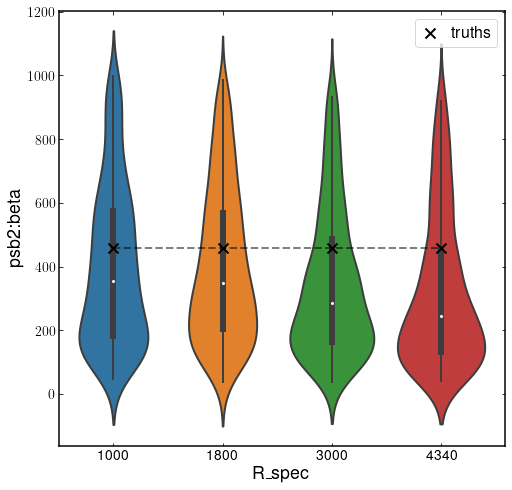

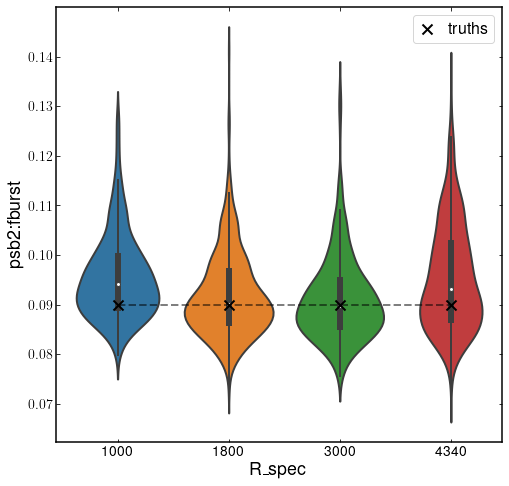

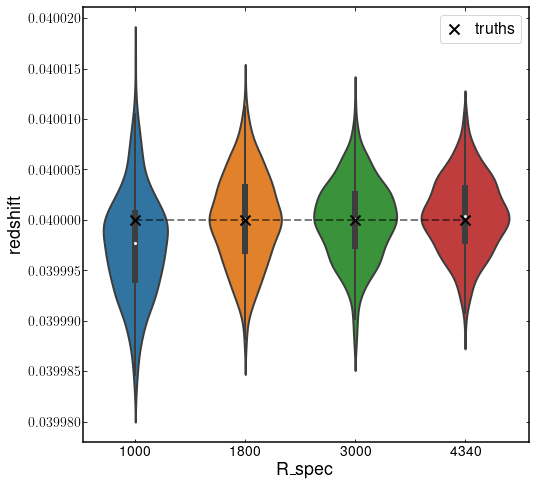

In [250]:
all_violin_plot()

Comments:
1. Dust properties are badly recovered, for all R_spec values. It is possible that Av and n are highly-correlated, which is confirmed by looking at corner plots: If Av drops, n_dust will increase, matching the truth value.
2. In general, higher R_spec does slightly better in recovering parameters, mainly on shrinking uncertainties. This is most visible in redshift. However, there are parameters that increasing R_spec does not help, but rather brings the posterior distribution away from the truth value or broadens the uncertainties. Examples include burstage, tau and fburst.
3. Contrary to how we have observed so far, all 4 fits over-estimated Mstar by roughly 30-40%. I do not know why this happens, considering that the fburst estimates are very accurate to the truth (~9% fburst), meaning that any increase in Mstar will require a proportional increase in A and F type stars in the spectrum, which could not be masked away through outshining. Perhaps there is some degeneracy between Mstar and dust parameters? Edit: checked corner plots, there is an inverse relationship between Mstar and n_dust, so this might be the reason to the overestimation. Checking the bin-by-1 fits on the original Yirui's mock datacube, there also exists this relationship.
4. Metallicity seems to be very well recovered and without obvious biases, perhaps the parameter other than redshift that can be most easily estimated. 